<a href="https://colab.research.google.com/github/DiploDatos/AprendizajePorRefuerzos/blob/master/lab_2_stable_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2

Integrantes: 

- Seppi, Santiago
- Richard, Felipe
- Lizondo, Nicolás

Consignas:

1. Crear tu propio entorno y entrenar agentes RL en el mismo. Analizar la convergencia con distintos algoritmos* (ej: PPO, DQN), resultados con distintas funciones de recompensa e híper-parámetros. 

    Algunas ideas:

    * Transformar GoLeftEnv en una grilla 2D, añadir paredes / trampas / agua.
    * Crear un entorno que juegue a algún juego como el ta-te-ti.
    * Crea un entorno totalmente nuevo que sea de tu interés!

2. Entrena agentes en entornos más complejos con stable-baselines/rl-baselines-zoo. Tener en cuenta:

    * Google Colab tiene una limitante en cuanto a cantidad de recursos de CPU/GPU (incluido un "rendimiento decreciente silencioso"), lo cuál reduce la capacidad de entrenar distintos entornos.
    * Si el entorno no está implementado en stable-baselines, debe hacerse un wrapper a mano, lo que puede ser sencillo o puede llevar algo más de trabajo, teniendo que tocar código subyacente de la librería. 

\* pueden ser usando stable-baselines/rl-baselines-zoo o bien utilizando algún otro algoritmo (incluso tabular)

# Resolución - Entrenando un agente para la batalla naval

Para este trabajo nos planteamos implementar un ambiente que simule el juego de la batalla naval en tableros pequeños (de 3x3 o  5x5), donde el objetivo del agente es encontrar el único crucero del enemigo, que en princpio ocupa tres casilleros. Inicialmente reproducimos el código propuesto por Alessio Tamburro en esta [página](https://towardsdatascience.com/an-artificial-intelligence-learns-to-play-battleship-ebd2cf9adb01). 

## Esquema de recompensas

Para cualquier acción en general $r = -1$

Sin embargo, si se realiza una acción que se considera inválida (como moverse hacia un casillero no vacío, o sea ya jugado previamente), la misma se penaliza haciendo $r = -2*S$ donde $S$ es la dimensión de tablero (la cantidad de celdas por lado). 

Por cada acción que acierta la posición del crucero:

$r = S$

Si se completa el juego (se aciertan todas las celdas del barco enemigo) el juego termina y:

$R = S*S$

### Importamos algunas librerias y definimos funciones

In [13]:
import gym
from gym import spaces
import numpy as np
import random

In [3]:
# randomly places a ship on a board
def set_ship(ship, ships, board, ship_locs):

    grid_size = board.shape[0]
    
    done = False
    while not done:
        init_pos_i = np.random.randint(0, grid_size)
        init_pos_j = np.random.randint(0, grid_size)
                    
        # for a cruiser, if init_oos_i = 0, move forward horizontally (+1)
        # for a cruiser, if init_oos_j = 0, move downward vertically (+1)
        move_j = grid_size - init_pos_j - ships[ship]# horizontal
        if move_j > 0:
            move_j = 1
        else:
            move_j = -1
        move_i = grid_size - init_pos_i - ships[ship] # vertical
        if move_i > 0:
            move_i = 1
        else:
            move_i = -1
        # choose if placing ship horizontally or vertically
        choice_hv = np.random.choice(['h', 'v']) # horizontal, vertical
        if choice_hv == 'h': #horizontal
            j = [(init_pos_j + move_j*jj) for jj in range(ships[ship])]
            i = [init_pos_i for ii in range(ships[ship])]
            pos = set(zip(i,j))     
            if all([board[i,j]==0 for (i,j) in pos]):
                done = True
        elif choice_hv == 'v':
            i = [(init_pos_i + move_i*ii) for ii in range(ships[ship])]
            j = [init_pos_j for jj in range(ships[ship])]
            pos = set(zip(i,j))        
            #check if empty board in this direction
            if all([board[i,j]==0 for (i,j) in pos]):
                done = True
    # set ship - see convention
    for (i,j) in pos:
        board[i,j] = 1
        ship_locs[ship].append((i,j))
    
    return board, ship_locs

def board_rendering(grid_size, board):
    for i in range(grid_size):
        print("-"*(4*grid_size+2))
        for j in range(grid_size):
            current_state_value = board[i,j]
            current_state = ('S' if current_state_value==1 else ' ')
            print(" | ", end="")
            print(current_state, end='')
        print(' |')
    print("-"*(4*grid_size+2))

In [94]:
class BattleshipEnv(gym.Env):
    
    """Custom Environment that follows gym interface"""
    """see https://github.com/openai/gym/blob/master/gym/core.py"""
    
    metadata = {'render.modes': ['human']} 


    def __init__(self, enemy_board, ship_locs, grid_size, ships):
        
        super(BattleshipEnv, self).__init__()
        
        #ships
        self.ships = ships
        
        # board size
        self.grid_size = grid_size 
        # cell state encoding (empty, hit, miss)
        self.cell = {'E': 0, 'X': 1, 'O': -1} 
        # boards, actions, rewards
        self.board = self.cell['E']*np.ones((self.grid_size, self.grid_size), dtype='int')
        # enemy_board must be encoded with 0: empy and 1: ship cell
        self.is_enemy_set = False
        self.enemy_board = enemy_board
        self.ship_locs = ship_locs
        if self.enemy_board is None:
            self.enemy_board = 0*np.ones((self.grid_size, self.grid_size), dtype='int')
            for ship in self.ships:
                self.ship_locs[ship] = []
                self.enemy_board, self.ship_locs = set_ship(ship, self.ships, self.enemy_board, self.ship_locs)
            self.is_enemy_set = True
        # reward discount
        self.rdisc = 0
        self.legal_actions = [] # legal (empty) cells available for moves
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))# this gets updated as an action is performed
        
        # Define action and observation space
        # They must be gym.spaces objects
        # In our case the action space is discrete: index of action
        self.action_space = spaces.Discrete(self.grid_size * self.grid_size)
        # The observation will be the state or configuration of the board
        self.observation_space = spaces.Box(low=-1, high=1,shape=(self.grid_size, self.grid_size), 
                                            dtype=np.int)
        #Ex: print(spaces.Box(0,1, shape=(10,10)).high)

    # action will be an index in action_space if from epsilon-greedy
    # or from model prediction
    def step(self, action):
                        
        # board situation before the action
        state = self.board.copy()        
        empty_cnts_pre, hit_cnts_pre, miss_cnts_pre = self.board_config(state)
        
        # action coordinates generated or predicted by the agent in the action_space
        i, j = np.unravel_index(action, (self.grid_size,self.grid_size))
        
        #print('action', action, 'coords', i, j)
        #print('legal_actions', self.legal_actions)
        
        # lose 1 point for any action
        reward = -1
        # assign a penalty for each illegal action used instead of a legal one
        if (i,j) not in self.legal_actions:
            reward -= 2*self.grid_size
            action_idx = np.random.randint(0,len(self.legal_actions))
            
            i,j = self.legal_actions[action_idx]                
            action = np.ravel_multi_index((i,j), (self.grid_size,self.grid_size))
        
        # set new state after performing action (scoring board is updated)
        self.set_state((i,j))
        # update legal actions and action_space
        self.set_legal_actions((i,j))

        # new state on scoring board - this includes last action
        next_state = self.board
               
        # board situation after action
        empty_cnts_post, hit_cnts_post, miss_cnts_post = self.board_config(next_state)

        # game completed?
        done = bool(hit_cnts_post == sum(self.ships.values()))
                    
        # reward for a hit
        if hit_cnts_post-hit_cnts_pre==1: 
            # Update hit counts and use it to reward
            r_discount = 1#0.5**self.rdisc
            rp = (self.grid_size*self.grid_size if done else self.grid_size)
            reward += rp*r_discount
            #print('HIT!!!')
            
        #if done:
        #    print('done')
            
        # we discount the reward for a subsequent hit the longer it takes to score it
        # after a hit, zero the discount 
        # don't start discounting though, if first hit hasn't happened yet
        #if hit_cnts_post-hit_cnts_pre==1 or hit_cnts_pre==0:
        #    self.rdisc = 0
        #else:
        #    self.rdisc += 1
                    
        reward = float(reward)
            
        #print('reward:', reward)
        # store the current value of the portfolio here
        info = {}

        return next_state, reward, done, info


    
    def reset(self):
        # Reset the state of the environment to an initial state
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """
        
        self.board = self.cell['E']*np.ones((self.grid_size, self.grid_size), dtype='int')
        
        self.legal_actions = [] # legal (empty) cells available for moves
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))# this gets updated as an action is performed
               
        # generate a random board again if it was set randomly before
        if self.is_enemy_set:
            self.enemy_board = 0*np.ones((self.grid_size, self.grid_size), dtype='int')
            self.ship_locs = {}
            for ship in self.ships:
                self.ship_locs[ship] = []
                self.enemy_board, self.ship_locs = set_ship(ship, self.ships, self.enemy_board, self.ship_locs)

        self.rdisc = 0

        return self.board
    
    # Render the environment to the screen
    # board (i,j)
    ## ------------>j
    ## | (0,0) | (0,1) | (0,2) | |
    ## | (1,0) | (1,1) | (1,2) | |
    ##                           v i
    def render(self, mode='human'):
        for i in range(self.grid_size):
            print("-"*(4*self.grid_size+2))
            for j in range(self.grid_size):
                current_state_value = self.board[i,j]
                current_state = list(self.cell.keys())[list(self.cell.values()).index(current_state_value)]
                current_state = (current_state if current_state!='E' else ' ')
                print(" | ", end="")
                print(current_state, end='')
            print(' |')
        print("-"*(4*self.grid_size+2))
        
    ####### HELPER FUNCTIONS ###########
    
    def board_config(self, state):
        uni_states, uni_cnts = np.unique(state.ravel(), return_counts=True)
        empty_cnts = uni_cnts[uni_states==self.cell['E']]
        hit_cnts = uni_cnts[uni_states==self.cell['X']]
        miss_cnts = uni_cnts[uni_states==self.cell['O']]
        if len(empty_cnts)==0:
            empty_cnts = 0
        else:
            empty_cnts = empty_cnts[0]
        if len(hit_cnts)==0:
            hit_cnts = 0
        else:
            hit_cnts = hit_cnts[0]
        if len(miss_cnts)==0:
            miss_cnts = 0
        else:
            miss_cnts = miss_cnts[0]
        
        return empty_cnts, hit_cnts, miss_cnts

    # set board configuration and state value after player action
    def set_state(self, action):
        i , j = action
        if self.enemy_board[i,j]==1:
            self.board[i,j]=self.cell['X']
        else:
            self.board[i,j]=self.cell['O']

    # set legal actions (empty board locations)
    def set_legal_actions(self, action):
        if action in self.legal_actions:
            self.legal_actions.remove(action)

En la siguiente celda puede verse cómo se comporta el agente en un solo episodio:

In [5]:
# ships
ships = {}
ships['cruiser'] = 3

grid_size=5
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

for ep in range(1):
    print('Episode', ep)
    obs = env.reset()
    #env.render()
    #print(env.enemy_board)
    done = False
    t = 0
    while not done:
        action = env.action_space.sample()
        i, j = np.unravel_index(action, (grid_size,grid_size))    
        print("Action {}".format(t + 1), i, j)
        obs, reward, done, _ = env.step(action)
        print('obs=', obs, 'reward=', reward, 'done=', done)
        env.render()
        t += 1
        if done:
            print("Goal reached!", "reward=", reward)

Episode 0
Action 1 0 0
obs= [[-1  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]] reward= -1.0 done= False
----------------------
 | O |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
Action 2 4 0
obs= [[-1  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  0]] reward= 4.0 done= False
----------------------
 | O |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 | X |   |   |   |   |
----------------------
Action 3 1 1
obs= [[-1  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  0]] reward= -1.0 done= False
----------------------
 | O |   |   |   |   |
----------------------
 |   | O |   |

<ipython-input-4-eb76dc1c6adb>:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [6]:
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import os

from stable_baselines3.common.results_plotter import load_results, ts2xy

from tensorflow.keras.backend import clear_session #not sure if we need this but it does not hurt

import matplotlib.pyplot as plt

In [7]:
## This callback function is legacy and needs to be replaced with object oriented functions
## to work with all policies. See next callback function

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every step_interval calls
    if (n_steps + 1) % step_interval == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            # NOTE: when done is True, timesteps are counted and reported to the log_dir
            mean_reward = np.mean(y[-episode_interval:]) # mean reward over previous episode_interval episodes
            mean_moves = np.mean(np.diff(x[-episode_interval:])) # mean moves over previous episode_interval episodes
            print(x[-1], 'timesteps') # closest to step_interval step number
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f} - Last mean moves per episode: {:.2f}".format(best_mean_reward, 
                                                                                           mean_reward, mean_moves))

            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    # Returning False will stop training early
    return True

In [8]:
from stable_baselines3.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, episode_interval: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.episode_interval = episode_interval
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model.pkl')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Evaluate policy training performance
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # NOTE: when done is True, timesteps are counted and reported to the log_dir
                mean_reward = np.mean(y[-self.episode_interval:]) # mean reward over previous episode_interval episodes
                mean_moves = np.mean(np.diff(x[-self.episode_interval:])) # mean moves over previous 100 episodes
                if self.verbose > 0:
                    print(x[-1], 'timesteps') # closest to step_interval step number
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f} - Last mean moves per episode: {:.2f}".format(self.best_mean_reward, 
                                                                                                   mean_reward, mean_moves))

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model")
                    self.model.save(self.save_path)

        return True

In [9]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, window = 100, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=window)
    y_moves = moving_average(np.diff(x), window = window) 
    # Truncate x
    x = x[len(x) - len(y):]
    x_moves = x[len(x) - len(y_moves):]

    title = 'Smoothed Learning Curve of Rewards (every ' + str(window) +' steps)'
    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.show()

    title = 'Smoothed Learning Curve of Moves (every ' + str(window) +' steps)'
    fig = plt.figure(title)
    plt.plot(x_moves, y_moves)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Moves')
    plt.title(title)
    plt.show()

## Prueba del modelo base sobre un tablero de 5x5 y un solo crucero

Lo primero que hicimos fue probar el modelo sobre un tablero de 5x5 y un un solo crucero de que ocupa 3 casilleros. Luego de correr con 250.000 movimientos, observamos que el agente logra encontrar al buque enemigo en 14 movimientos.

In [95]:
clear_session()

# ships -- keep only one kind for 5x5 grid
ships = {}
ships['cruiser'] = 3

grid_size = 5
num_timesteps = 250000 # this is number of moves and not number of episodes

best_mean_reward, n_steps, step_interval, episode_interval = -np.inf, 0, 10000, 10000

# Instantiate the env
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

# wrap it
log_dir = "./gym/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, filename=log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

<ipython-input-94-eb76dc1c6adb>:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [96]:
# Train the agent - Note: best model is not save in Callback function for PPO2; save manually
model = PPO('MlpPolicy', env, verbose=0).learn(total_timesteps=num_timesteps,callback=callback)

9998 timesteps
Best mean reward: -inf - Last mean reward per episode: -59.55 - Last mean moves per episode: 19.29
Saving new best model
19991 timesteps
Best mean reward: -59.55 - Last mean reward per episode: -57.60 - Last mean moves per episode: 19.22
Saving new best model
29983 timesteps
Best mean reward: -57.60 - Last mean reward per episode: -55.92 - Last mean moves per episode: 19.07
Saving new best model
39992 timesteps
Best mean reward: -55.92 - Last mean reward per episode: -54.14 - Last mean moves per episode: 18.89
Saving new best model
49991 timesteps
Best mean reward: -54.14 - Last mean reward per episode: -53.39 - Last mean moves per episode: 18.83
Saving new best model
59989 timesteps
Best mean reward: -53.39 - Last mean reward per episode: -51.88 - Last mean moves per episode: 18.68
Saving new best model
69990 timesteps
Best mean reward: -51.88 - Last mean reward per episode: -50.83 - Last mean moves per episode: 18.56
Saving new best model
80000 timesteps
Best mean rewa

In [97]:
model.save(log_dir + 'best_model_cruiser_5x5_250000moves.pkl')

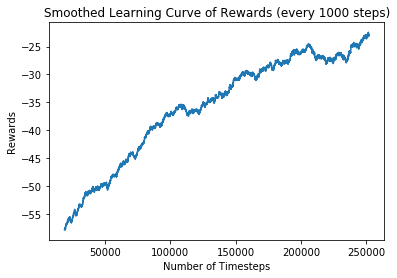

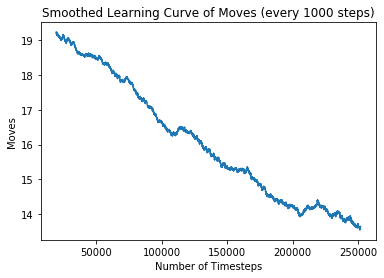

In [98]:
plot_results(log_dir, 1000)

## Prueba del modelo base modificado

Algo que observamos en la implementación inicial es que puede elegir una acción no permitida  (ilegal o repetida) reiteradas veces, con lo cual intentamos probar qué pasaba si forzábamos a que la siguiente acción se tome siempre del listado que nos da **env.legal_actions**. En la siguiente celda lo probamos de manera manual:

In [92]:
import random

# ships
ships = {}
ships['cruiser'] = 3

grid_size=5
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

for ep in range(1):
    print('Episode', ep)
    obs = env.reset()
    #env.render()
    #print(env.enemy_board)
    done = False
    t = 0
    a = [np.ravel_multi_index((i,j), (5,5)) for i,j in list(env.legal_actions)]
    
    while not done:
        action = random.sample(a,1)[0]
        i, j = np.unravel_index(action, (grid_size,grid_size))    
        print("Action {}".format(t + 1), i, j)
        obs, reward, done, _ = env.step(action)
        a = [np.ravel_multi_index((i,j), (5,5)) for i,j in list(env.legal_actions)]
        print('obs=', obs, 'reward=', reward, 'done=', done)
        env.render()
        t += 1
        if done:
            print("Goal reached!", "reward=", reward)

Episode 0
Action 1 2 2
obs= [[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]] reward= -1.0 done= False
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   | O |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
Action 2 1 1
obs= [[ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]] reward= 4.0 done= False
----------------------
 |   |   |   |   |   |
----------------------
 |   | X |   |   |   |
----------------------
 |   |   | O |   |   |
----------------------
 |   |   |   |   |   |
----------------------
 |   |   |   |   |   |
----------------------
Action 3 4 2
obs= [[ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  0  0]] reward= -1.0 done= False
----------------------
 |   |   |   |   |   |
----------------------
 |   | X |   |

<ipython-input-91-eb76dc1c6adb>:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


En la celda anterior, la acción la forzamos _manualmente_ para que este restringida sí o sí al espacio de acciones legales. Al correr el agente en varios episodios con StableBaselines, es necesario modificar este comportamiento en la clase **BattleshipEnv()**. En ese sentido, le hicimos dos modificaciones al código:

- En primer lugar, introducimos el cambio ya mencionado, de tomar la acción dentro del espacio de acciones legales. Sin embargo, no eliminamos la posibilidad de que el agente se equivoque y elija una acción _ilegal_, porque notamos que eso lo ayudaba a aprender mejor al tener una gran penalización.

- En segundo lugar, **en caso de acertar un casillero**, le indicamos al agente que busque su próxima acción en las celdas vecinas, para aumentar las posibilidades de tener un nuevo acierto. Sobre esas celdas vecinas también ponemos la restricción se que pertenezcan al espacio de acciones legales (es decir, que no las haya repetido antes). 

El código con la re-definición de la clase **BattleshipEnv()** se encuentra a continuación:

In [99]:
class BattleshipEnv(gym.Env):
    
    """Custom Environment that follows gym interface"""
    """see https://github.com/openai/gym/blob/master/gym/core.py"""
    
    metadata = {'render.modes': ['human']} 


    def __init__(self, enemy_board, ship_locs, grid_size, ships):
        
        super(BattleshipEnv, self).__init__()
        
        #ships
        self.ships = ships
        
        # board size
        self.grid_size = grid_size 
        # cell state encoding (empty, hit, miss)
        self.cell = {'E': 0, 'X': 1, 'O': -1} 
        # boards, actions, rewards
        self.board = self.cell['E']*np.ones((self.grid_size, self.grid_size), dtype='int')
        # enemy_board must be encoded with 0: empy and 1: ship cell
        self.is_enemy_set = False
        self.enemy_board = enemy_board
        self.ship_locs = ship_locs
        if self.enemy_board is None:
            self.enemy_board = 0*np.ones((self.grid_size, self.grid_size), dtype='int')
            for ship in self.ships:
                self.ship_locs[ship] = []
                self.enemy_board, self.ship_locs = set_ship(ship, self.ships, self.enemy_board, self.ship_locs)
            self.is_enemy_set = True
        # reward discount
        self.rdisc = 0
        self.legal_actions = [] # legal (empty) cells available for moves
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))# this gets updated as an action is performed
        
        # Define action and observation space
        # They must be gym.spaces objects
        # In our case the action space is discrete: index of action
        self.action_space = spaces.Discrete(self.grid_size * self.grid_size)
        # The observation will be the state or configuration of the board
        self.observation_space = spaces.Box(low=-1, high=1,shape=(self.grid_size, self.grid_size), 
                                            dtype=np.int)
        #Ex: print(spaces.Box(0,1, shape=(10,10)).high)

    # action will be an index in action_space if from epsilon-greedy
    # or from model prediction
    def step(self, action):
                        
        # board situation before the action
        state = self.board.copy()        
        empty_cnts_pre, hit_cnts_pre, miss_cnts_pre = self.board_config(state)
        
        # action coordinates generated or predicted by the agent in the action_space
        i, j = np.unravel_index(action, (self.grid_size,self.grid_size))
        

        
        # lose 1 point for any action
        reward = -1
        # assign a penalty for each illegal action used instead of a legal one
        if (i,j) not in self.legal_actions:
            reward -= 2*self.grid_size
            l_a = [np.ravel_multi_index((i,j), (self.grid_size,self.grid_size)) for i,j in list(self.legal_actions)]
            action = random.sample(l_a,1)[0]
            
#             action_idx = np.random.randint(0,len(self.legal_actions))
            i, j = np.unravel_index(action, (self.grid_size,self.grid_size))

            
        # set new state after performing action (scoring board is updated)
        self.set_state((i,j))
        # update legal actions and action_space
        self.set_legal_actions((i,j))

        # new state on scoring board - this includes last action
        next_state = self.board
               
        # board situation after action
        empty_cnts_post, hit_cnts_post, miss_cnts_post = self.board_config(next_state)

        # game completed?
        done = bool(hit_cnts_post == sum(self.ships.values()))
        
        
        # reward for a hit
        if hit_cnts_post-hit_cnts_pre==1: 
            # Update hit counts and use it to reward
            r_discount = 1#0.5**self.rdisc
            rp = (self.grid_size*self.grid_size if done else self.grid_size)
            reward += rp*r_discount
            #print('HIT!!!')
            
            #If there was a HIT, choose next action from the sorrounding cells in the board,
            # in order to make it easier to find the ship. Make sure this choice is within
            # the legal actions
            
            a = [(i,j+1), (i,j-1), (i+1,j), (i-1,j)]
#             print(f'Coordenadas donde buscar: {a}')
#             print(f'Espacio de acciones legales: {self.legal_actions}')
            
            a = [value for value in a if value in list(self.legal_actions)]

            
            #If no sorrounding cells are within the legal_actions, choose randomly from another location:
            
            if len(a) == 0 and len(list(self.legal_actions)) != 0:
                l_a = [np.ravel_multi_index((i,j), (self.grid_size,self.grid_size)) for i,j in list(self.legal_actions)]
                action = random.sample(l_a,1)[0]
            elif len(list(self.legal_actions)) != 0:          
                l_a = [np.ravel_multi_index((value), (self.grid_size,self.grid_size)) for value in a]
                action = random.sample(l_a,1)[0]
            else:
                pass
            
            i, j = np.unravel_index(action, (self.grid_size,self.grid_size))
            
                    
        reward = float(reward)
        
        # set new state after performing action (scoring board is updated)
        self.set_state((i,j))
        # update legal actions and action_space
        self.set_legal_actions((i,j))

        # new state on scoring board - this includes last action
        next_state = self.board
               
        # board situation after action
        empty_cnts_post, hit_cnts_post, miss_cnts_post = self.board_config(next_state)

        # game completed?
        done = bool(hit_cnts_post == sum(self.ships.values()))
            
        #print('reward:', reward)
        # store the current value of the portfolio here
        info = {}

        return next_state, reward, done, info


    
    def reset(self):
        # Reset the state of the environment to an initial state
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """
        
        self.board = self.cell['E']*np.ones((self.grid_size, self.grid_size), dtype='int')
        
        self.legal_actions = [] # legal (empty) cells available for moves
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))# this gets updated as an action is performed
               
        # generate a random board again if it was set randomly before
        if self.is_enemy_set:
            self.enemy_board = 0*np.ones((self.grid_size, self.grid_size), dtype='int')
            self.ship_locs = {}
            for ship in self.ships:
                self.ship_locs[ship] = []
                self.enemy_board, self.ship_locs = set_ship(ship, self.ships, self.enemy_board, self.ship_locs)

        self.rdisc = 0

        return self.board
    
    # Render the environment to the screen
    # board (i,j)
    ## ------------>j
    ## | (0,0) | (0,1) | (0,2) | |
    ## | (1,0) | (1,1) | (1,2) | |
    ##                           v i
    def render(self, mode='human'):
        for i in range(self.grid_size):
            print("-"*(4*self.grid_size+2))
            for j in range(self.grid_size):
                current_state_value = self.board[i,j]
                current_state = list(self.cell.keys())[list(self.cell.values()).index(current_state_value)]
                current_state = (current_state if current_state!='E' else ' ')
                print(" | ", end="")
                print(current_state, end='')
            print(' |')
        print("-"*(4*self.grid_size+2))
        
    ####### HELPER FUNCTIONS ###########
    
    def board_config(self, state):
        uni_states, uni_cnts = np.unique(state.ravel(), return_counts=True)
        empty_cnts = uni_cnts[uni_states==self.cell['E']]
        hit_cnts = uni_cnts[uni_states==self.cell['X']]
        miss_cnts = uni_cnts[uni_states==self.cell['O']]
        if len(empty_cnts)==0:
            empty_cnts = 0
        else:
            empty_cnts = empty_cnts[0]
        if len(hit_cnts)==0:
            hit_cnts = 0
        else:
            hit_cnts = hit_cnts[0]
        if len(miss_cnts)==0:
            miss_cnts = 0
        else:
            miss_cnts = miss_cnts[0]
        
        return empty_cnts, hit_cnts, miss_cnts

    # set board configuration and state value after player action
    def set_state(self, action):
        i , j = action
        if self.enemy_board[i,j]==1:
            self.board[i,j]=self.cell['X']
        else:
            self.board[i,j]=self.cell['O']

    # set legal actions (empty board locations)
    def set_legal_actions(self, action):
        if action in self.legal_actions:
            self.legal_actions.remove(action)

In [83]:
clear_session()

# ships -- keep only one kind for 5x5 grid
ships = {}
ships['cruiser'] = 3
# ships['destroyer'] = 2

grid_size = 5
num_timesteps = 250000 # this is number of moves and not number of episodes

best_mean_reward, n_steps, step_interval, episode_interval = -np.inf, 0, 10000, 10000

# Instantiate the env
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

# wrap it
log_dir = "./gym/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, filename=log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

<ipython-input-82-1938e69926b9>:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [84]:
# Train the agent - Note: best model is not save in Callback function for PPO2; save manually
model = PPO('MlpPolicy', env, verbose=0).learn(total_timesteps=num_timesteps,callback=callback)

9991 timesteps
Best mean reward: -inf - Last mean reward per episode: -44.56 - Last mean moves per episode: 15.62
Saving new best model
20000 timesteps
Best mean reward: -44.56 - Last mean reward per episode: -41.86 - Last mean moves per episode: 15.39
Saving new best model
29998 timesteps
Best mean reward: -41.86 - Last mean reward per episode: -40.52 - Last mean moves per episode: 15.26
Saving new best model
39985 timesteps
Best mean reward: -40.52 - Last mean reward per episode: -39.26 - Last mean moves per episode: 15.11
Saving new best model
49983 timesteps
Best mean reward: -39.26 - Last mean reward per episode: -37.49 - Last mean moves per episode: 14.88
Saving new best model
59985 timesteps
Best mean reward: -37.49 - Last mean reward per episode: -35.53 - Last mean moves per episode: 14.63
Saving new best model
69990 timesteps
Best mean reward: -35.53 - Last mean reward per episode: -33.78 - Last mean moves per episode: 14.36
Saving new best model
79997 timesteps
Best mean rewa

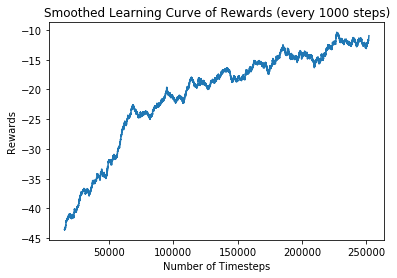

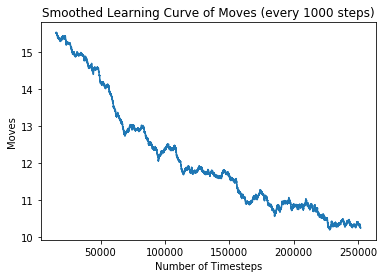

In [85]:
plot_results(log_dir, 1000)

In [87]:
model.save(log_dir + 'best_model_cruiser_2_5x5_250000moves.pkl')

**Para un tablero de 5x5 con solo un crucero de 3 casilleros, vemos que la cantidad de movimientos en promedio mejora de 14 a 10.**

## Ver cómo juega el agente en el mejor modelo encontrado:

La siguiente celda es interactiva: Permite visualizar las jugadas que va haciendo el agente paso a paso

In [100]:
model_best = PPO.load('./gym/best_model_cruiser_2_5x5_250000moves.pkl')


In [103]:
from IPython.display import clear_output
import time

ships = {}
ships['cruiser'] = 3
# ships['destroyer'] = 2

grid_size=5
enemy_board = 0*np.ones((grid_size, grid_size), dtype='int')
#enemy_board[3,5] = 1
#enemy_board[4,5] = 1
#enemy_board[5,5] = 1
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)
a = [np.ravel_multi_index((i,j), (5,5)) for i,j in list(env.legal_actions)]
# give me time to setup recording
time.sleep(5)
for ep in range(10):
    obs = env.reset()
    ## 2 empty boards
    done = False
    nmoves = 0
    print('episode no.', ep, '# moves:', nmoves)
    env.render()
    env.render()
    time.sleep(5)
    clear_output(wait=True)        
    while not done:
#         action, obs = model_best.predict(obs, deterministic=True)
        action = random.sample(a,1)[0]
        a = [np.ravel_multi_index((i,j), (5,5)) for i,j in list(env.legal_actions)]
        obs, _, done , _ = env.step(action)
        nmoves += 1
        print('episode no.', ep, '# moves:', nmoves)
        env.render()
        board_rendering(grid_size, env.enemy_board)
        time.sleep(np.random.uniform(1,3))
        clear_output(wait=True)        

## Cambio de hiperparámetros

Las pruebas anteriores se realizaron con valores de hiperparámetros por defecto. En esta sección buscamos optimizar el valor de _gamma_ para una tasa de aprendizaje definida, ayudándonos con la librería _hyperopt_.

Esta librería permite hacer una búsqueda en distintos espacios de hiperparámetros de manera similar a _GridSearchCV_ o _RandomizedSearch_ que se usan en entornos de aprendizaje supervisado, de manera tal de encontrar la combinación de los mismos que da el mejor resultado. Nosotros decidimos centrarnos solamente en _gamma_ ya que estas búsquedas demandan muchos recursos del sistema.

In [105]:
# !pip install hyperopt

In [121]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

# Agent hyperparameter optimization
def objective(space, env_copies = 1):
    


    gamma = space['gamma']
    learning_rate = space['learning_rate']
    

    
    print('space:', space)
    
    # ships
    ships = {}
    ships['cruiser'] = 3

    grid_size = 5

    # Instantiate the env
    env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

    env = DummyVecEnv([lambda: env]*env_copies)
      
    model = PPO('MlpPolicy', env, verbose=0, 
                 gamma=gamma,
                 learning_rate=learning_rate,
               ).learn(total_timesteps=num_timesteps)
        
    rewards_mean = []
    moves_mean = []
    n_episodes = 100
    for ep in range(n_episodes):
        reward_env = []
        moves_env = []
        for env_i in env.envs:
            obs = env_i.reset()
            done = False
            rewards_sum = 0
            moves = 0
            while not done:
                action, obs = model.predict(obs, deterministic=True)
                obs, reward, done , _ = env_i.step(action)
                rewards_sum += reward # total reward for this episode
                moves += 1
            reward_env.append(rewards_sum)
            moves_env.append(moves)
        rewards_mean.append(np.min(reward_env)) # avg environment reward 
        moves_mean.append(np.mean(moves_env)) # avg environment reward 
    rewards_mean = np.mean(rewards_mean)
    moves_mean = np.mean(moves_mean)

    print('reward', rewards_mean, 'moves', moves_mean)
    
    # hyperopt will minimize objective, number of moves in this case
    return{'loss': moves_mean, 'status': STATUS_OK }

In [122]:
space = {
    'gamma': hp.choice('gamma', [0.99, 0.95, 0.9]), 
    'learning_rate': hp.choice('learning_rate', [0.0007])
}


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30, 
            trials=trials, verbose=1)

space:                                                
{'gamma': 0.99, 'learning_rate': 0.0007}              
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

<ipython-input-99-1938e69926b9>:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)



reward                                                
12.57                                                 
moves                                                 
6.88                                                  
space:                                                               
{'gamma': 0.99, 'learning_rate': 0.0007}                             
reward                                                               
15.92                                                                
moves                                                                
6.58                                                                 
space:                                                               
{'gamma': 0.95, 'learning_rate': 0.0007}                             
reward                                                               
0.79                                                                 
moves                                                                
8.01      

Luego de hacer la busqueda, _Hyperopt_ nos devuelve que el gamma óptimo es de 0.9, para una tasa de aprendizaje de 0.0007:

In [123]:
param_dist = space_eval(space, best)
param_dist

{'gamma': 0.9, 'learning_rate': 0.0007}

In [126]:
clear_session()

# ships -- keep only one kind for 5x5 grid
ships = {}
ships['cruiser'] = 3
# ships['destroyer'] = 2

grid_size = 5
num_timesteps = 250000 # this is number of moves and not number of episodes

best_mean_reward, n_steps, step_interval, episode_interval = -np.inf, 0, 10000, 10000

# Instantiate the env
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

# wrap it
log_dir = "./gym/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, filename=log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

<ipython-input-99-1938e69926b9>:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [128]:
# Train the agent - Note: best model is not save in Callback function for PPO2; save manually
model = PPO('MlpPolicy', env, verbose=0, gamma = 0.9, learning_rate = 0.0007).learn(total_timesteps=num_timesteps,callback=callback)

9978 timesteps
Best mean reward: -inf - Last mean reward per episode: -46.85 - Last mean moves per episode: 16.29
Saving new best model
20000 timesteps
Best mean reward: -46.85 - Last mean reward per episode: -39.98 - Last mean moves per episode: 15.40
Saving new best model
29994 timesteps
Best mean reward: -39.98 - Last mean reward per episode: -36.80 - Last mean moves per episode: 15.01
Saving new best model
39994 timesteps
Best mean reward: -36.80 - Last mean reward per episode: -34.64 - Last mean moves per episode: 14.74
Saving new best model
49997 timesteps
Best mean reward: -34.64 - Last mean reward per episode: -32.51 - Last mean moves per episode: 14.42
Saving new best model
59999 timesteps
Best mean reward: -32.51 - Last mean reward per episode: -31.07 - Last mean moves per episode: 14.16
Saving new best model
69998 timesteps
Best mean reward: -31.07 - Last mean reward per episode: -29.43 - Last mean moves per episode: 13.81
Saving new best model
79999 timesteps
Best mean rewa

Al entrenar al agente con estos hiperparámetros, no solo mejora la recompensa y se reducen los movimientos en promedio por juego; sino que también las curvas tienen un comportamiento más lineal: Es decir que el aprendizaje del agente tiene menos volatilidad que en los otros casos:

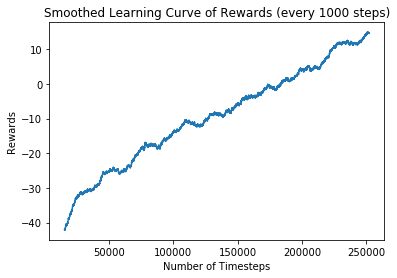

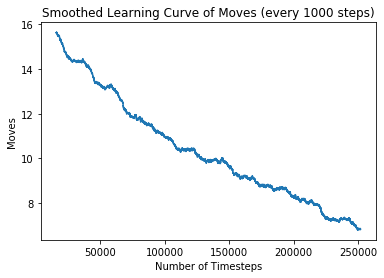

In [129]:
plot_results(log_dir, 1000)

In [130]:
model.save(log_dir + 'best_model_cruiser_2_5x5_250000moves_gamma09.pkl')

Lo probamos aumentando un valor el valor de la tasa de aprendizale, a 0.001:

In [133]:
clear_session()

# ships -- keep only one kind for 5x5 grid
ships = {}
ships['cruiser'] = 3
# ships['destroyer'] = 2

grid_size = 5
num_timesteps = 250000 # this is number of moves and not number of episodes

best_mean_reward, n_steps, step_interval, episode_interval = -np.inf, 0, 10000, 10000

# Instantiate the env
env = BattleshipEnv(enemy_board=None, ship_locs={}, grid_size=grid_size, ships=ships)

# wrap it
log_dir = "./gym/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, filename=log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

<ipython-input-99-1938e69926b9>:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [134]:
# Train the agent - Note: best model is not save in Callback function for PPO2; save manually
model = PPO('MlpPolicy', env, verbose=0, gamma = 0.9, learning_rate = 0.001).learn(total_timesteps=num_timesteps,callback=callback)

9999 timesteps
Best mean reward: -inf - Last mean reward per episode: -40.19 - Last mean moves per episode: 15.31
Saving new best model
19998 timesteps
Best mean reward: -40.19 - Last mean reward per episode: -39.97 - Last mean moves per episode: 15.32
Saving new best model
29990 timesteps
Best mean reward: -39.97 - Last mean reward per episode: -36.80 - Last mean moves per episode: 15.02
Saving new best model
39984 timesteps
Best mean reward: -36.80 - Last mean reward per episode: -34.38 - Last mean moves per episode: 14.69
Saving new best model
49999 timesteps
Best mean reward: -34.38 - Last mean reward per episode: -32.92 - Last mean moves per episode: 14.37
Saving new best model
59996 timesteps
Best mean reward: -32.92 - Last mean reward per episode: -31.11 - Last mean moves per episode: 14.06
Saving new best model
69989 timesteps
Best mean reward: -31.11 - Last mean reward per episode: -29.36 - Last mean moves per episode: 13.72
Saving new best model
79998 timesteps
Best mean rewa

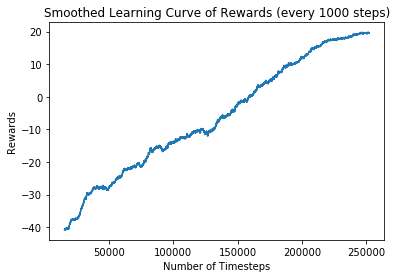

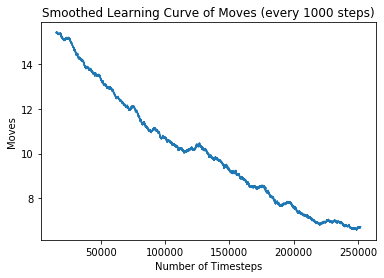

In [136]:
plot_results(log_dir, 1000)

In [135]:
model.save(log_dir + 'best_model_cruiser_2_5x5_250000moves_gamma09_b.pkl')

## Conclusiones

- A lo largo de las distintas pruebas que hicimos, pudimos observar que es importante permitir que el agente "se equivoque" y elija una celda repetida o _ilegal_ , y que se le aplique una penalidad extra por ello. Cuando sacamos esa posibilidad (que no se equivocara, en el sentido de repetir jugadas como lo haría un humao), el agente no terminaba aprendiendo bien. Eso es algo que lo diferencia claramente del comportamiento de una persona.

- Al incorporar la modificación de que, en caso de tener un acierto, la acción siguiente se restrinja a las celdas contiguas mejoró significativamente los resultados.

- Los parámetros del modelo tienen peso en los resultados finales. Aquí probamos solo con algunas combinaciones de _gamma_ y de la tasa de aprendizaje, pero sería ideal hacer una optimización de parámetros a partir de una búsqueda más exhaustiva.